In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import matplotlib.gridspec as gridspec

data_path = '../data/engineered_customer_data.csv'
df = pd.read_csv(data_path)

In [33]:
df['CustomerID'].nunique()

4362

In [2]:
# Convert CustomerID to string:
df['CustomerID'] = df['CustomerID'].astype(str)
df = df.convert_dtypes()

In [3]:
def plot_feature_distribution(df, feature_list, row_num, row_col, title):
    fig, axes = plt.subplots(nrows=row_num, ncols=row_col,figsize=(15,12))
    fig.suptitle(title, size = 18)
    for r in range(row_num):
        for c in range(row_col):
            list_id = r*row_col+c
            axes[r,c].set_title(feature_list[list_id])
            sns.histplot(df[feature_list[list_id]], kde=True, ax=axes[r,c])
            plt.tight_layout()
            plt.subplots_adjust(top=0.9)

In [4]:
feature_list = ['Days_Since_Last_Transaction',
                'Total_Orders_Count',
                'Total_Prod_Purchased',
                'Total_Spent',
                'Avg_Order_Value',
                'Uniq_Prod_Purchased_Count',
                'Avg_Days_Btw_Order',
                'Fav_DoW',
                'Fav_Hour',
                'is_UK',
                'Cancellation_Count',
                'Total_Transaction_Count',
                'Cancellation_Rate',
                'Avg_Monthly_Spending',
                'Std_Monthly_Spending']

len(feature_list)

15

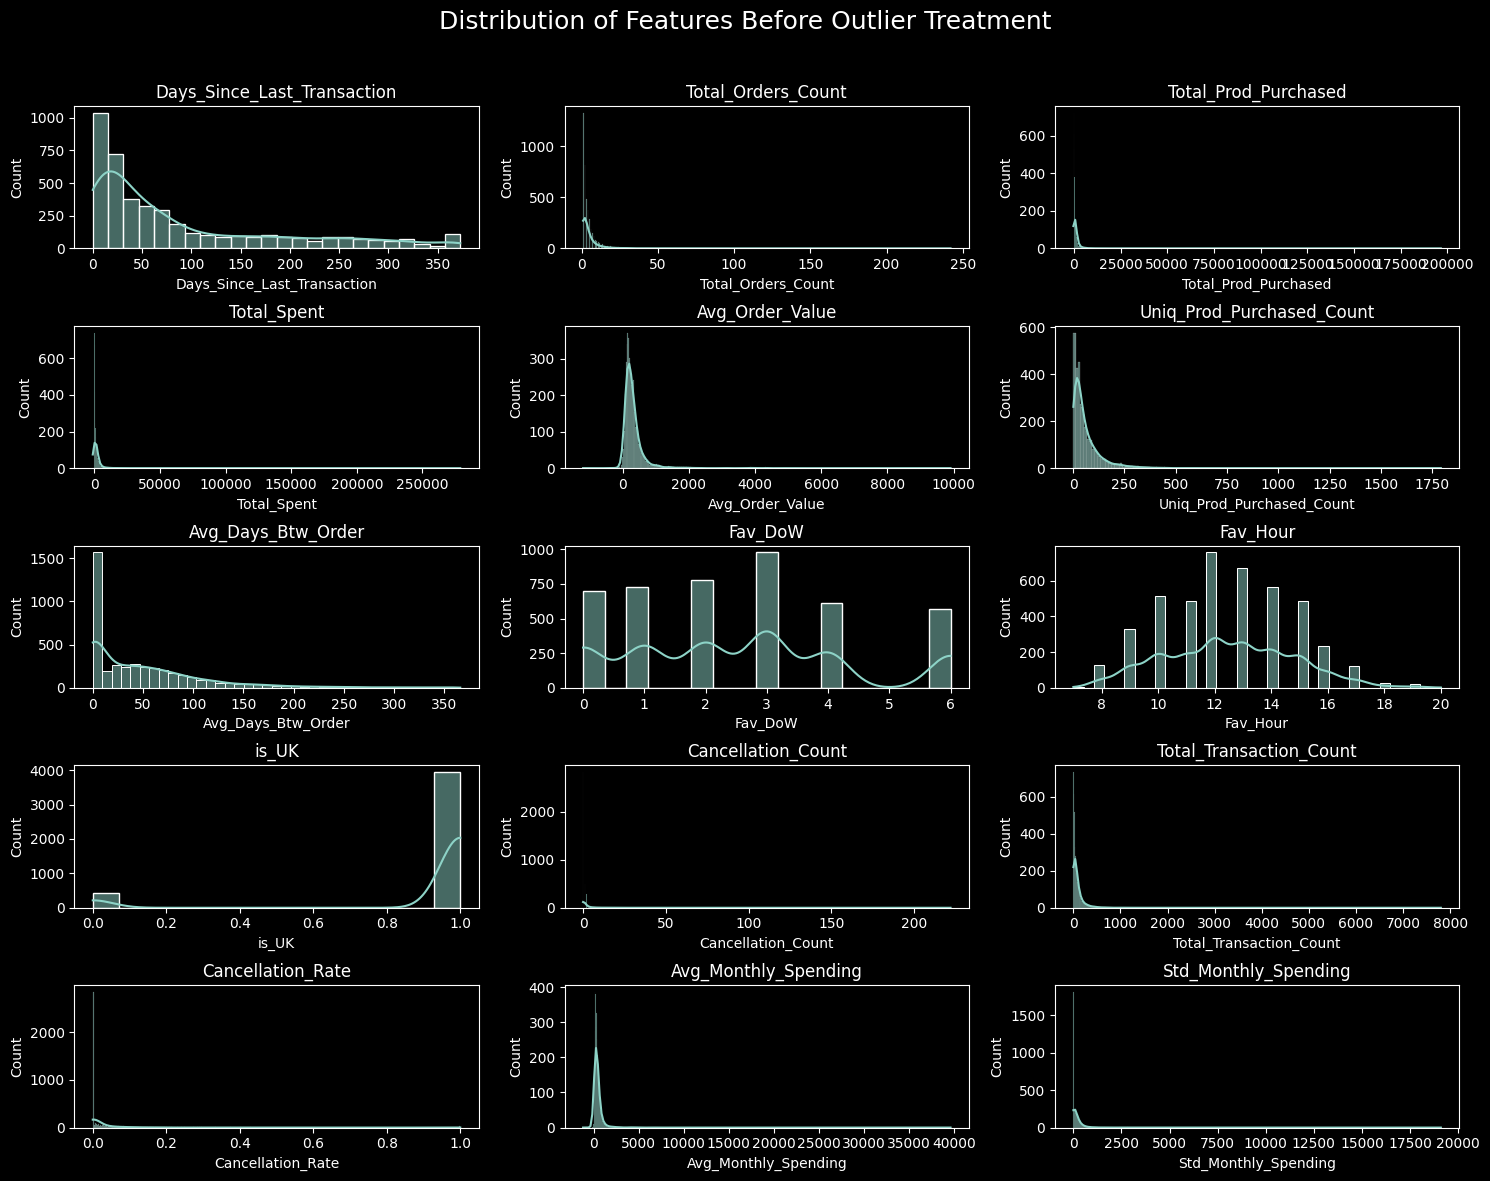

In [5]:
# Plotting the distribution of features before outlier treatment
plot_feature_distribution(df, feature_list, 5, 3, 'Distribution of Features Before Outlier Treatment')

### Outlier Detection and Treatment

#### IQR Method

#### Isolation Forest Method

In [6]:
from sklearn.ensemble import IsolationForest

model = IsolationForest(contamination=0.05, random_state=0)

# Fit the model to the data:
np_data = df.iloc[:, 1:].to_numpy()
df['Outlier_Score'] = model.fit_predict(np_data)
df['Is_Outlier'] = [1 if x == -1 else 0 for x in df['Outlier_Score']]
cleaned_df = df[df['Is_Outlier'] == 0]
outlier_df = df[df['Is_Outlier'] == 1]

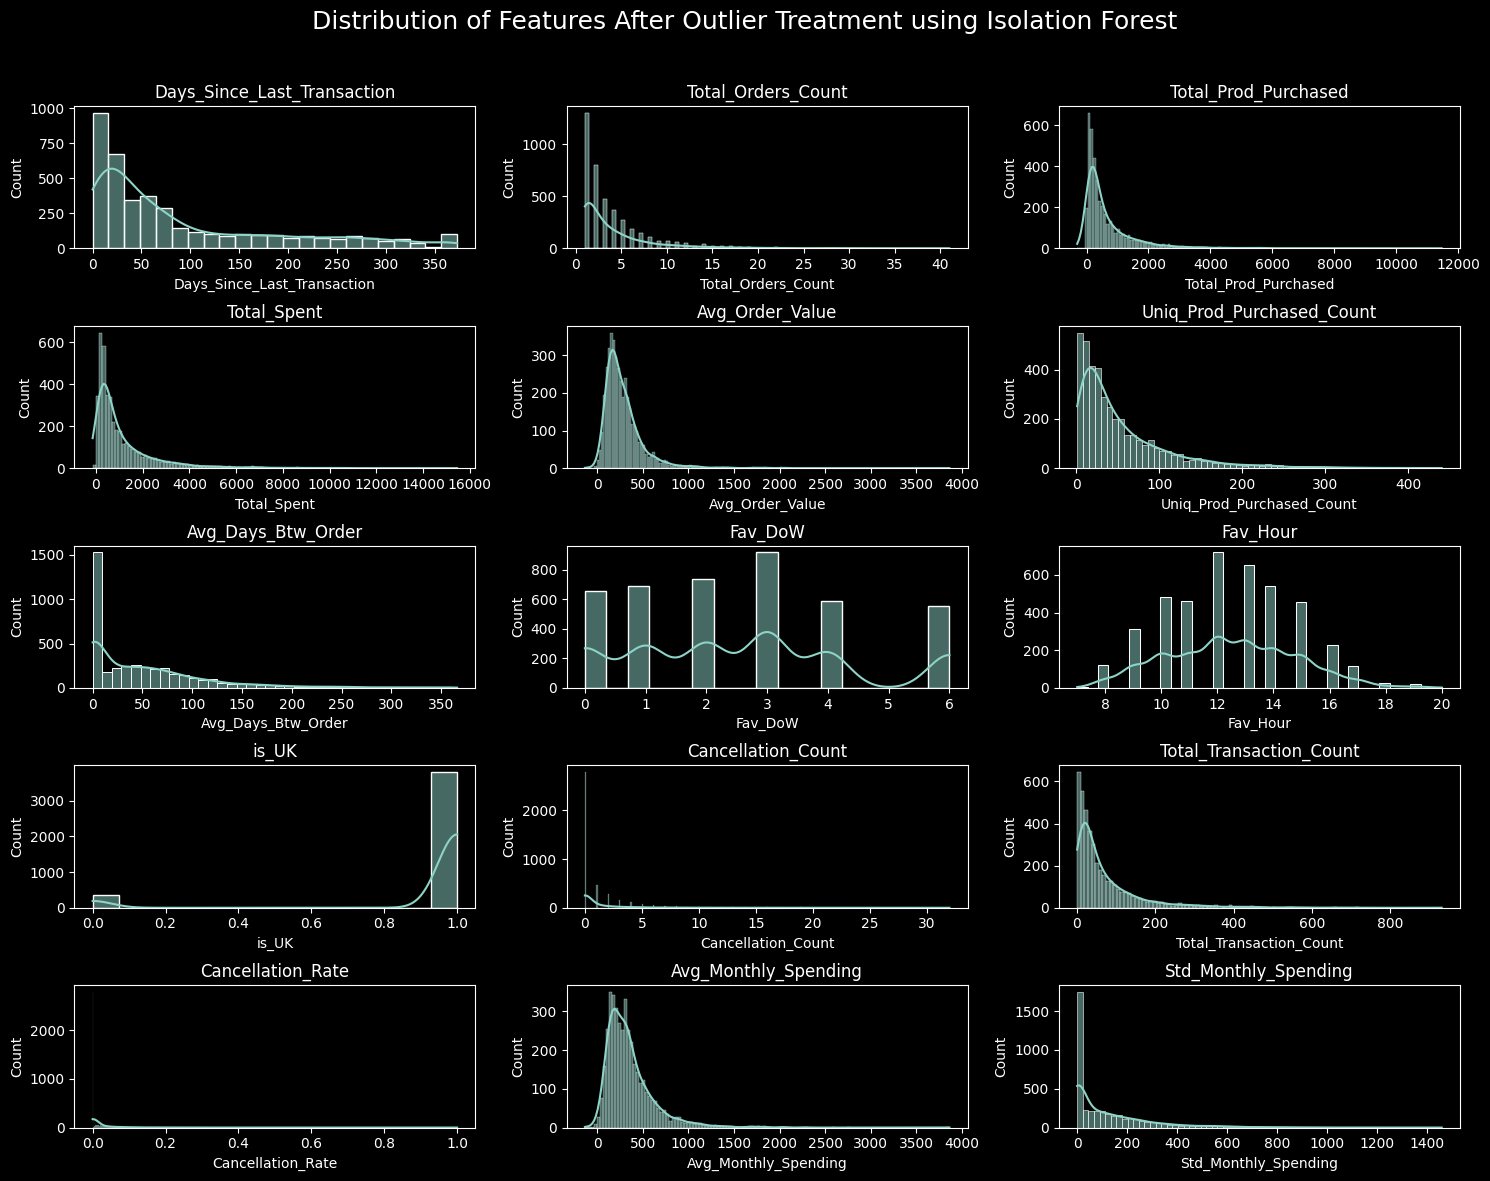

In [7]:
# Plotting distributions of features after dropping outliers
plot_feature_distribution(cleaned_df, feature_list, 5, 3, 'Distribution of Features After Outlier Treatment using Isolation Forest')

### Correlation Analysis

In [8]:
cleaned_df = cleaned_df.drop(columns=['Outlier_Score', 'Is_Outlier'])
cleaned_df.reset_index(drop=True, inplace=True)

In [9]:
corr_df = cleaned_df.drop(columns=['CustomerID']).corr()

In [10]:
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask, k=1)] = True

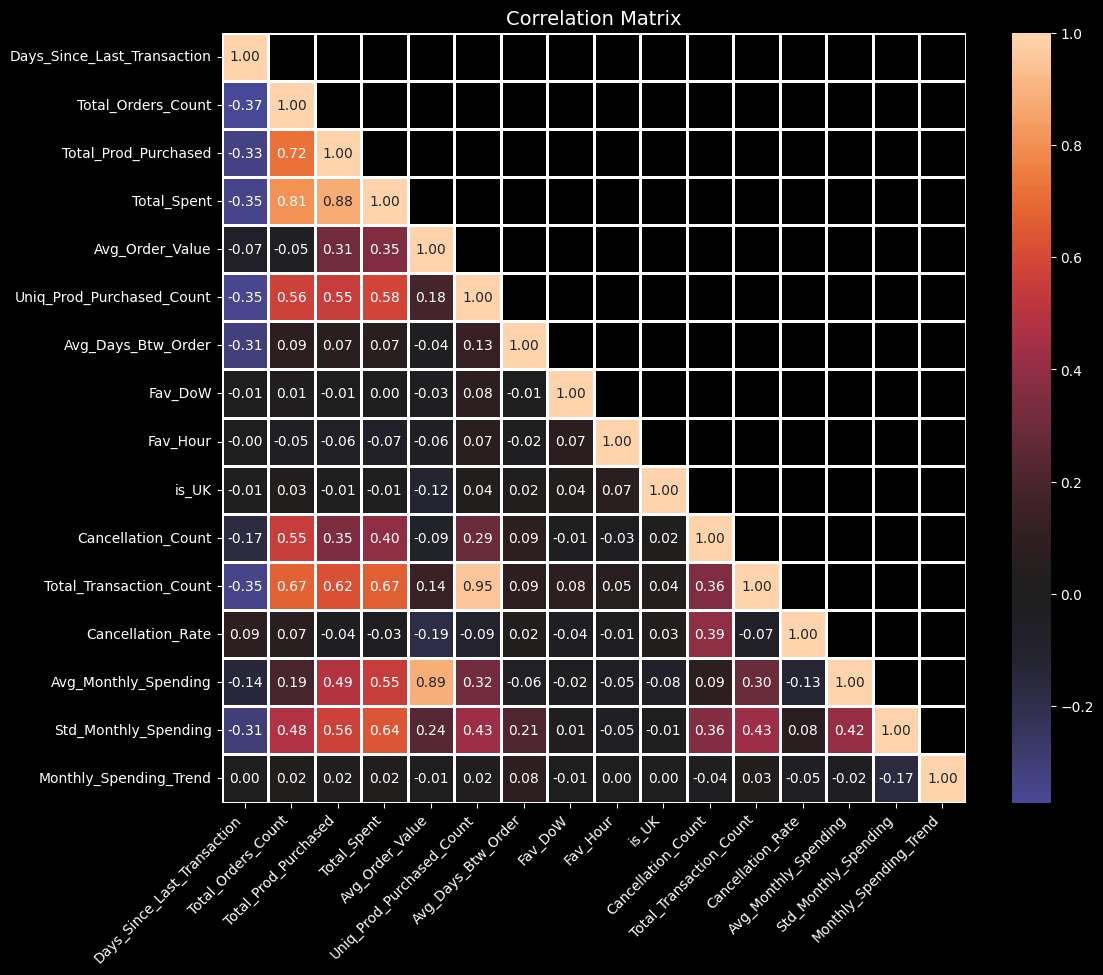

In [11]:
plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, mask=mask, annot=True, center=0, fmt='.2f', linewidths=2)
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix', fontsize=14)
plt.show()


**Some conclusions on the correlation of features**: There are some pairs of features that have high correlation, for example: 

- `Total_Prod_Purchased` and `Total_Orders_Count` (0.72)
- `Total_Spent` and `Total_Prod_Purchased` (0.88)
- `Total_Spent` and `Total_Order_Count` (0.81)
- `Total_Transaction_Count` and `Uniq_Prod_Purchased_Count` (0.95)
- `Avg_Monthly_Spending` and `Avg_Order_Value` (0.89)

**When multicolinearity exists in a clustering problem,** (k-means clustering in this case), it might be beneficial to treat multicolinearity by applying dimensionality reduction technique (for example, PCA). WHY?

### Feature Scaling

**The following features are not required to rescale**: 
- `CustomerID`: This feature is only an unique identifier between customers. 
- `Is_UK`: Binary (0, 1) value that indicates whether a customer is from UK or not. 
- `Fav_DoW`: This is a categorical feature with all possible values are from 1 to 7, so rescaling this feature is unnecessary.

In [12]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

excluded_cols = ['CustomerID', 'Fav_DoW', 'Fav_Hour', 'is_UK']
scaling_features = cleaned_df.columns.difference(excluded_cols)

# Create a copy of the data:
scaled_data = cleaned_df.copy()

# Apply the scaler to the data:
scaled_data[scaling_features] = scaler.fit_transform(scaled_data[scaling_features])

scaled_data.head()

,CustomerID,Days_Since_Last_Transaction,Total_Orders_Count,Total_Prod_Purchased,Total_Spent,Avg_Order_Value,Uniq_Prod_Purchased_Count,Avg_Days_Btw_Order,Fav_DoW,Fav_Hour,is_UK,Cancellation_Count,Total_Transaction_Count,Cancellation_Rate,Avg_Monthly_Spending,Std_Monthly_Spending,Monthly_Spending_Trend
0,12346,2.307940,-0.466056,-0.744246,-0.787724,-1.271603,-0.913924,-0.810973,1,10,1,-0.079157,-0.768348,6.244932,-1.299268,-0.714680,0.087429
1,12347,-0.909531,0.656281,1.942875,2.235598,1.458724,0.847419,0.125428,1,14,0,-0.412098,1.209696,-0.308052,0.950889,1.291048,0.114046
2,12348,-0.182363,-0.017121,1.805130,0.220453,0.321724,-0.568563,0.641118,3,19,0,-0.412098,-0.493620,-0.308052,0.013848,0.484249,-0.511132
3,12349,-0.750152,-0.690523,-0.055521,0.234699,5.191768,0.312109,-0.810973,0,9,0,-0.412098,0.000891,-0.308052,4.027419,-0.714680,0.087429
4,12350,2.158522,-0.690523,-0.529976,-0.581212,0.033887,-0.654903,-0.810973,2,16,0,-0.412098,-0.614500,-0.308052,-0.223369,-0.714680,0.087429


### Dimensionality Reduction

#### Applying PCA (Principle Component Analysis) method:

In [13]:
# Import PCA from sklearn:
from sklearn.decomposition import PCA

# Set the CustomerID as the index:
scaled_data.set_index('CustomerID', inplace=True)

In [14]:
# Apply PCA to the scaled data:
pca = PCA().fit(scaled_data)
explained_var_ratio = pca.explained_variance_ratio_
cumm_explained_var = np.cumsum(explained_var_ratio)

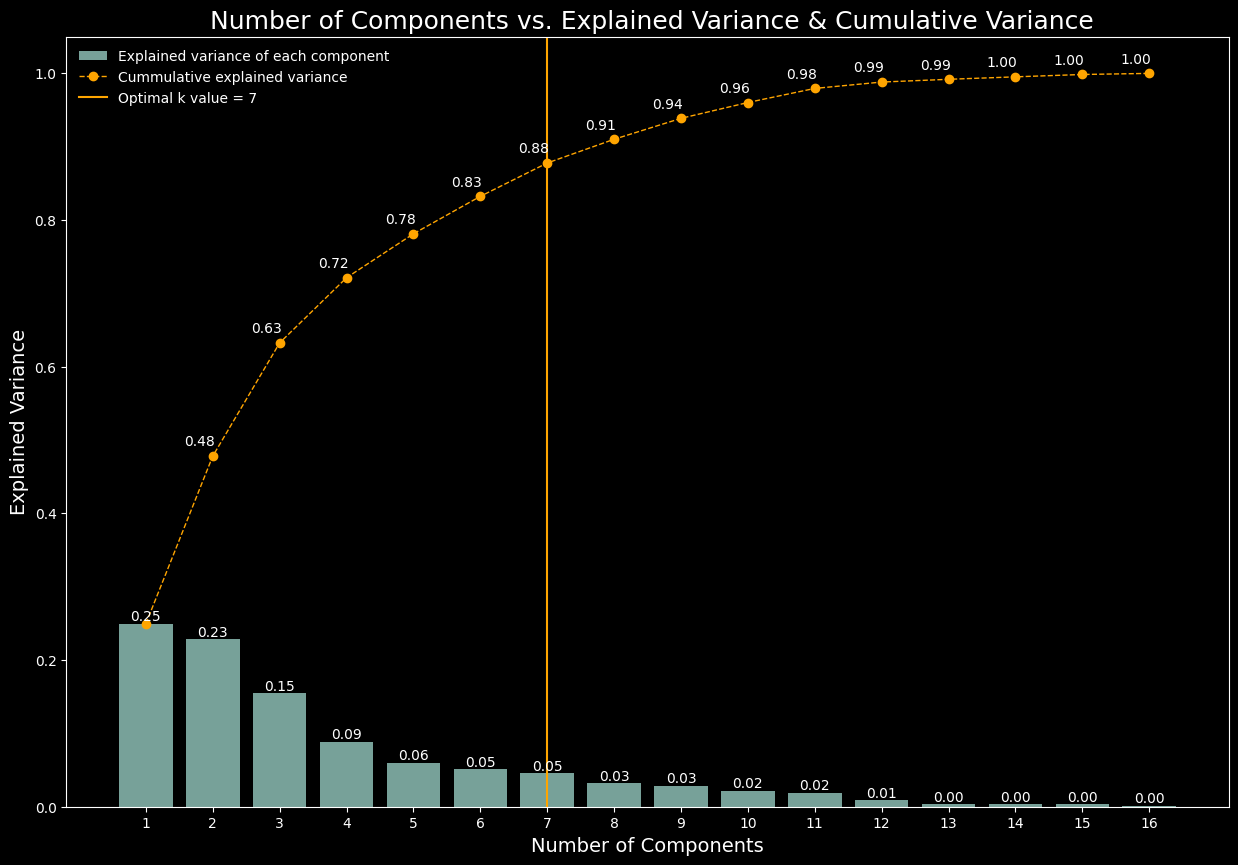

In [15]:
# Plot the explained variance of each component 
plt.figure(figsize=(15, 10))
num_comp = len(cumm_explained_var)
bar_plot = sns.barplot(x=[i for i in range(1, num_comp+1)], 
                       y=explained_var_ratio,
                       alpha=0.8)

# Plot the cummulative explained variance of each component


line_plot, = plt.plot(range(0, num_comp), cumm_explained_var, 
                    marker = 'o', linestyle='--', linewidth=1, color='orange')

plt.xlabel('Number of Components', fontsize=14)
plt.ylabel('Explained Variance', fontsize=14)
plt.title(' Number of Components vs. Explained Variance & Cumulative Variance', fontsize=18)

# Display the variance values:
x_offset = -0.2
y_offset = 0.01
for i, (a, b) in enumerate(zip(explained_var_ratio, cumm_explained_var)):
    plt.text(i, a, f"{a:.2f}", ha='center', va='bottom', fontsize=10)
    if i > 0:
        plt.text(i + x_offset, b + y_offset, f"{b:.2f}", ha="center", va="bottom", fontsize=10)

# Plotting the decided optimal k-value vertical line:
k_opt = 7
opt_k_line = plt.axvline(k_opt-1, color='orange', 
                         label='Optimal k value = {k_opt}')

# Display legends and ticks:
plt.xticks(range(0, num_comp))
plt.legend(handles = [bar_plot.patches[0], line_plot, opt_k_line], 
           labels=['Explained variance of each component', 'Cummulative explained variance', f'Optimal k value = {k_opt}'],
           framealpha=0,  
           loc='best')

plt.show()

In [16]:
# Create a PCA object with n_components = k_opt:
pca = PCA(n_components=k_opt)
pca_data = pca.fit_transform(scaled_data)

# Create new df from pca_data with PC columns:
pca_data = pd.DataFrame(pca_data, columns=['PC' + str(i+1) for i in range(pca.n_components_)])

pca_data.index = scaled_data.index

In [17]:
pca_data.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7
CustomerID,,,,,,,
12346,-1.758212,-3.561266,-1.034019,-3.177834,3.974222,-0.448273,-1.847990
12347,-0.003033,3.683822,-2.091501,1.365171,-0.313112,0.110850,0.002491
12348,5.866263,2.476481,-0.821642,0.692708,0.224001,1.042395,0.067634
12349,-4.335919,0.113652,-2.214096,5.542693,0.819221,0.546747,-1.051947
12350,3.794715,-1.000619,-1.017670,0.843630,0.897432,-1.107361,-0.154147


#### Applying Elbow Method to find optimal k (number of cluster) for K-Means Clustering:

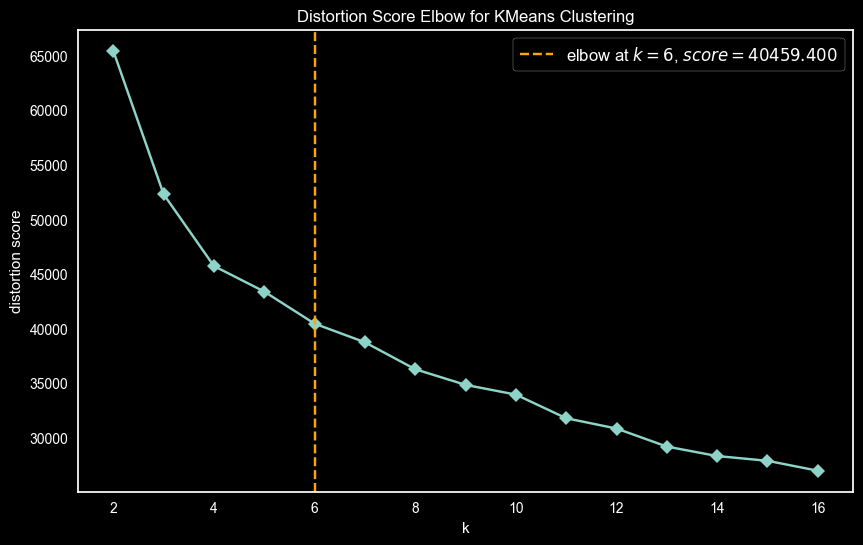

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [18]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer

kmean= KMeans(init='k-means++', n_clusters=10, random_state=0)

plt.style.use("dark_background")
# Plot Distortion Score to find optimal k value using Elbow Method:
fig, ax = plt.subplots(figsize=(10, 6))

visualizer = KElbowVisualizer(kmean, k=(2, 17), timings=False, ax=ax)
plt.grid(False)

# Fit the data to the visualizer:
visualizer.fit(pca_data)
visualizer.ax.lines[1].set_color('orange')
visualizer.show()

#### Applying Silhouette Method to find optimal k (number of cluster) for K-Means Clustering:

In [19]:
def compute_silhouette(df, k_start, k_stop, figsize=(12,10)):
    silhouette_scores = []
    # Check every k value from k_start to k_stop:
    for k in range(k_start, k_stop+1):
        # Create a KMeans model with k clusters:
        kmeans = KMeans(n_clusters=k, init='k-means++',
                        n_init=10, max_iter=100, random_state=0)
        kmeans.fit(df)
        labels = kmeans.predict(df)
        score = silhouette_score(df, labels, metric='euclidean')
        silhouette_scores.append(score)

    k_opt = silhouette_scores.index(max(silhouette_scores)) + k_start

    # Plot the silhouette scores:

    plt.figure(figsize=figsize)
    plt.style.use("dark_background", )
    plt.grid(False)
    plt.plot(range(k_start, k_stop+1), silhouette_scores, marker='o')
    plt.xlabel('Number of Clusters (k)', fontsize=14)
    plt.ylabel('Silhouette Score', fontsize=14)
    plt.title('Silhouette Score vs. Number of Clusters', fontsize=18)
    plt.axvline(k_opt, color='orange', label=f'Optimal k value = {k_opt}')
    plt.legend(framealpha=0, loc='best', fontsize=12)
    plt.show()

    return k_opt

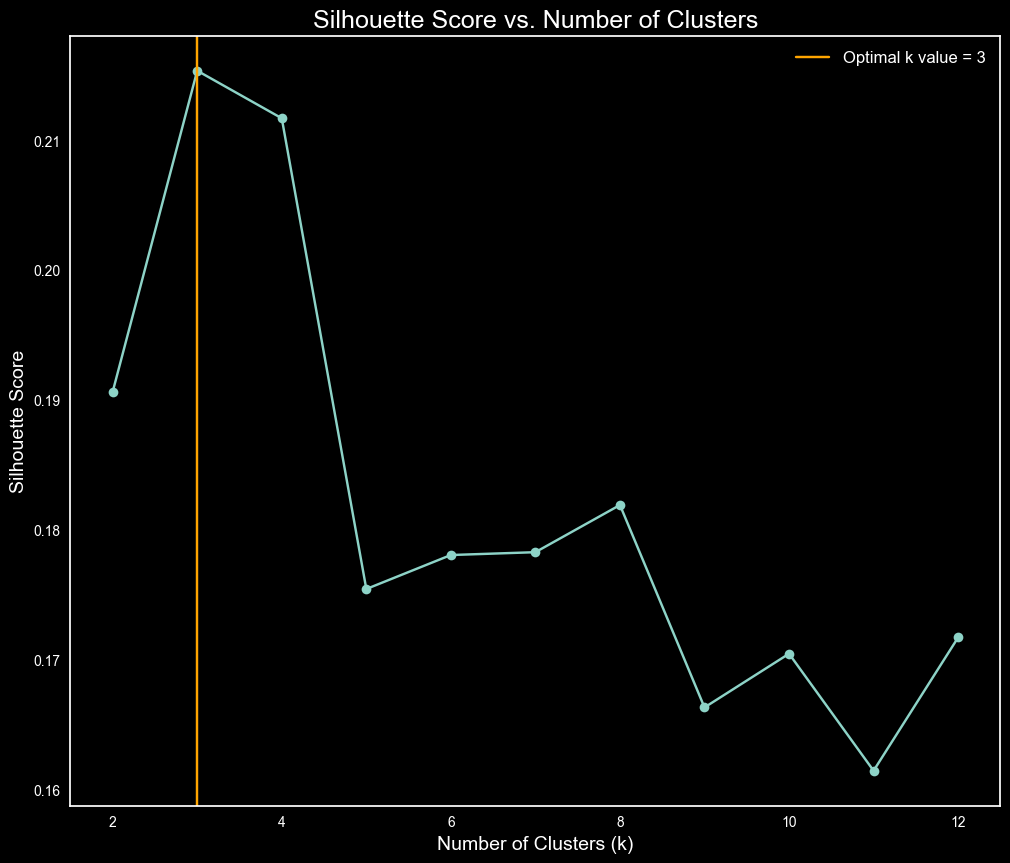

In [20]:
k_opt = compute_silhouette(pca_data, 2, 12)

In [21]:
def plot_silhouette_plot(df, k_start, k_stop, figsize=(20, 15)):
    plt.style.use("dark_background")
    plt.figure(figsize=figsize)
    grid = gridspec.GridSpec(k_stop - k_start + 1, 2, hspace=0.4, )

    # Plot the silhouette plots for each k value:
    for i in range(k_start, k_stop+1):
        kmeans = KMeans(n_clusters=i, init='k-means++',
                        n_init=10, max_iter=100, random_state=0)
        row_id, col_id = divmod(i-k_start, 2)

        ax = plt.subplot(grid[row_id, col_id])
        ax.grid(visible=False)
        visualizer = SilhouetteVisualizer(kmeans, colors='yellowbrick', ax=ax)
        visualizer.fit(df)

        # Add the silhouette score to the plot:
        score = silhouette_score(df, kmeans.labels_)
        ax.text(0.97, 0.02, f'Silhouette Score: {score:.2f}', fontsize=12, \
                ha='right', transform=ax.transAxes, color='orange')
        ax.set_title(f'Silhouette Plot for k={i} clusters, score={score:.2f}', fontsize=14)
        # ax.set_xlabel('Silhouette Coefficient Values', fontsize=14)

    # plt.tight_layout()
    plt.show()


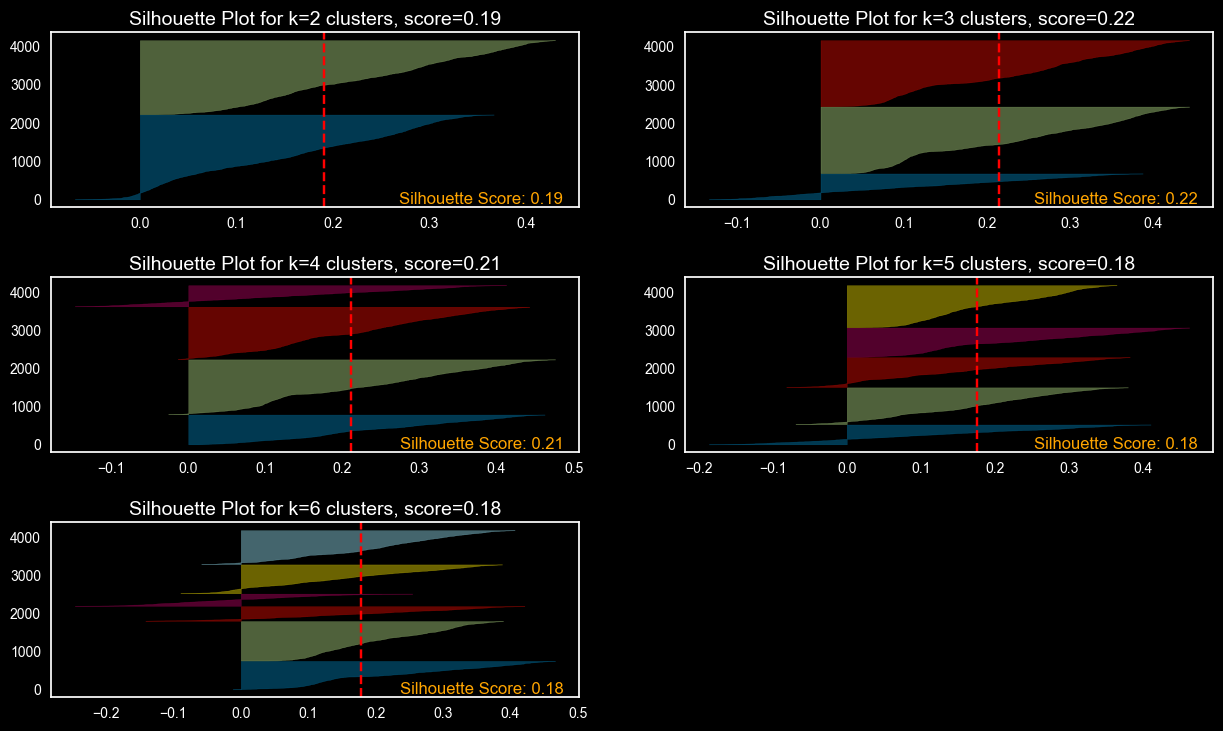

In [22]:
plot_silhouette_plot(pca_data, 2, 6, figsize=(15, 15))

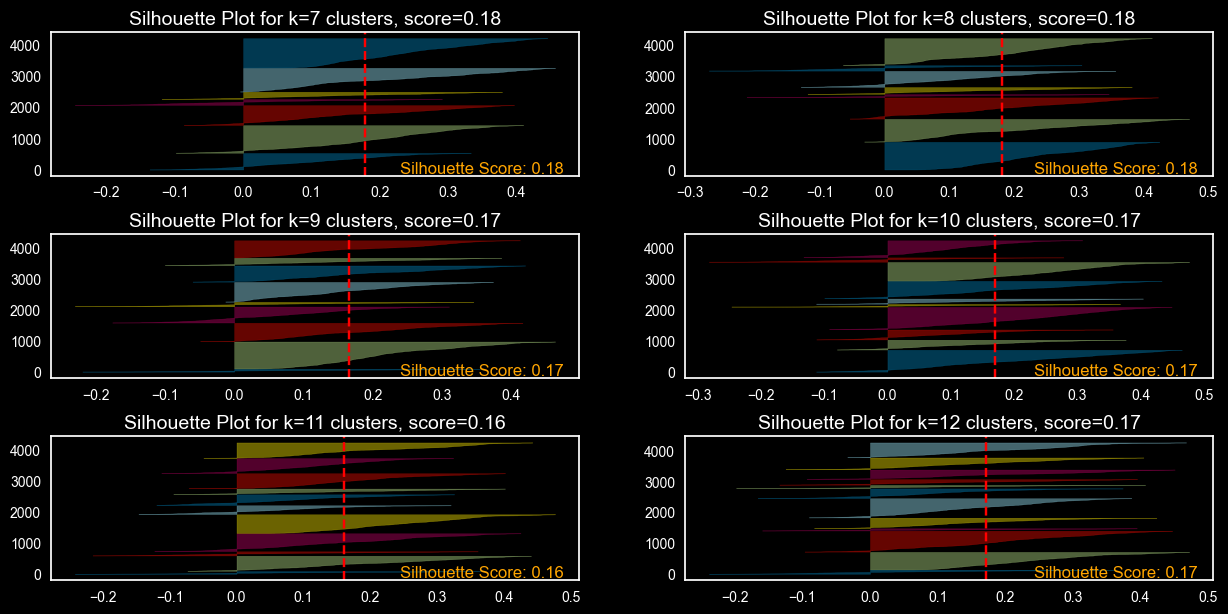

In [23]:
plot_silhouette_plot(pca_data, 7, 12, figsize=(15, 15))

### K-Means Clustering Model:

In [29]:
# We found out that the optimal cluster value, k-value, is 3: 
k_cluster = 3

# Create a KMeans model with k clusters:
kmeans = KMeans(n_clusters=k_cluster, init='k-means++',
                n_init=10, max_iter=100, random_state=0)
kmeans.fit(pca_data)

# Add the cluster labels to the pca data:
pca_data['Cluster_Label'] = kmeans.labels_

# Add the cluster labels to the original data:
cleaned_df['Cluster_Label'] = kmeans.labels_

In [ ]:
# 3D Visualization of top 3 PCA components
cluster_color = ['#0000CD', '#008000', '#7d1211']
cluster_0 = pca_data[pca_data['Cluster_Label'] == 0]
cluster_1 = pca_data[pca_data['Cluster_Label'] == 1]
cluster_2 = pca_data[pca_data['Cluster_Label'] == 2]

# Distribution of 3 clusters in the dataset: 
cluster_dist = (pca_data['Cluster_Label'].value_counts(normalize=True) * 100).reset_index()
cluster_dist.columns = ['Cluster Label', 'Percentage']

# Horizontal Plot of Cluster Distribution:
plt.figure(figsize=(10, 6))
plt.style.use("dark_background")

bar_plot = sns.barplot(x='Percentage', y='Cluster Label',
                        orient='h', data=cluster_dist, palette=cluster_color)

for index, value in enumerate(cluster_dist['Percentage']):
    plt.text(value+0.5, index, f'{value:.2f}%')

plt.title('Clusters Distribution', fontsize=14)
plt.xticks(ticks=np.arange(0, 50, 5))
plt.xlabel('Percentage (%)')

# Remove gridline
plt.grid(False)

# Show the plot
plt.show()


In [31]:
# Create a 3D scatter plot:
import plotly.graph_objects as go
fig = go.Figure(data=[go.Scatter3d( x=pca_data['PC1'], 
                                    y=pca_data['PC2'], 
                                    z=pca_data['PC3'], mode='markers', 
                                    marker=dict(size=5, color=pca_data['Cluster_Label'], 
                                                colorscale=cluster_color, 
                                                opacity=0.8 ) )])

# Set the title and layout details
fig.update_layout(
    title=dict(text='3D Visualization of Customer Clusters in PCA Space', x=0.5),
    scene=dict(
        xaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC1'),
        yaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC2'),
        zaxis=dict(backgroundcolor="#fcf0dc", gridcolor='white', title='PC3'),
    ),
    width=900,
    height=800
)

# Show the plot
fig.show()

#### Visualization of Customer's Behaviors across 3 clusters:

#### Evaluation Metrics: 

In [27]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
X = pca_data.drop(columns='Cluster_Label', axis=1)

# !. Silhouette Score
sil_score = silhouette_score(X, pca_data['Cluster_Label'])

# 2. Calinski-Harabasz Score (Variance Ratio Criterion)
c_h_score = calinski_harabasz_score(X, pca_data['Cluster_Label'])

# 3: Davies Bouldin Score (Avg. Similarity between a cluster and its most similar cluster)
d_b_score = davies_bouldin_score(X, pca_data['Cluster_Label'])

# Dataframe to store the scores:
score_df = pd.DataFrame({'Silhouette Score': [sil_score],
                         'Calinski-Harabasz Score': [c_h_score],
                         'Davies-Bouldin Score': [d_b_score]})
display(score_df.round(3))


,Silhouette Score,Calinski-Harabasz Score,Davies-Bouldin Score
0,0.215,1068.379,1.509
